In [190]:
# Johann Hatzius

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import StandardScaler
import scipy
from datetime import datetime
from datetime import timedelta


precipitation = pd.read_csv("Daily Precipitation.csv")
soil = pd.read_csv("Daily Soil Mositure.csv")
temperature = pd.read_csv("Daily Temperature.csv")
ndvi = pd.read_csv("Eight Day NDVI.csv")
production = pd.read_csv("Production Quantity.csv")

features = [precipitation, soil, temperature, ndvi]


def find_weekly_sum(x, precip_df, temp_df, soil_df):
    row = ndvi.iloc[x]
    start = row["start_date"]
    end = row["end_date"]
    dates_precip = (precip_df["start_date"] >= start) & (precip_df["start_date"] <= end)
    dates_temp = (temp_df["start_date"] >= start) & (temp_df["start_date"] <= end)
    dates_soil = (soil_df["start_date"] >= start) & (soil_df["start_date"] <= end)
    precip_sum = precip_df.loc[dates_precip]["precip"].sum()
    mean_temp = temp_df.loc[dates_temp]["temp"].mean()
    mean_soil_moisture = soil_df.loc[dates_soil]["smos"].mean()
    new_cols = [precip_sum, mean_temp, mean_soil_moisture]
    return new_cols

def find_regions():
    regions = production["region_id"].tolist()
    return set(regions)

def build_features_df():
    regions = find_regions()
    precip_col = []
    temp_col = []
    smos_col = []
    for region in regions:
        precip_df = precipitation[precipitation["region_id"] == region]
        temp_df = temperature[temperature["region_id"] == region]
        soil_df = soil[soil["region_id"] == region]
        ndvi_df = ndvi[ndvi["region_id"] == region]
        new_cols = [find_weekly_sum(x, precip_df, temp_df, soil_df) for x in ndvi_df.index]
        new_cols = np.array(new_cols).transpose()
        new_cols = new_cols.tolist()
        precip_col += new_cols[0]
        temp_col += new_cols[1]
        smos_col += new_cols[2]
    ndvi["precip"] = precip_col
    ndvi["temp"] = temp_col
    ndvi["smos"] = smos_col
    features_df = ndvi
    return features_df

def normalize_data(features_df):
    features = ["ndvi", "precip", "temp", "smos"]
    for feature in features:
        scaler = StandardScaler()
        data = np.array(features_df[feature]).reshape(-1,1)
        scaler.fit(data)
        features_df[feature] = scaler.transform(data)
    return features_df

In [194]:
features_df = build_features_df()
features_df = normalize_data(features_df)

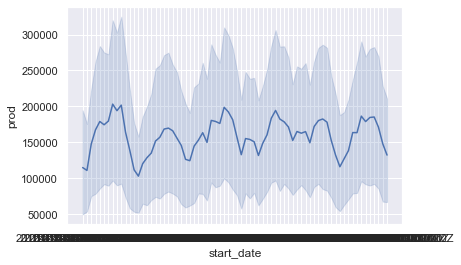

In [205]:
seaborn.set()
fig = seaborn.lineplot(x="start_date", y="prod", data=production)

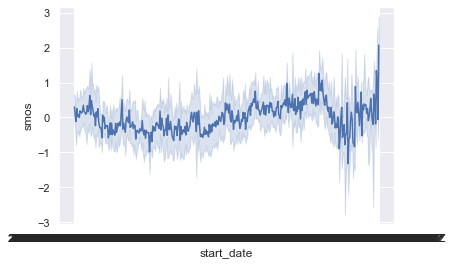

In [206]:
seaborn.set()
fig2 = seaborn.lineplot(x="start_date", y="smos", data=features_df)

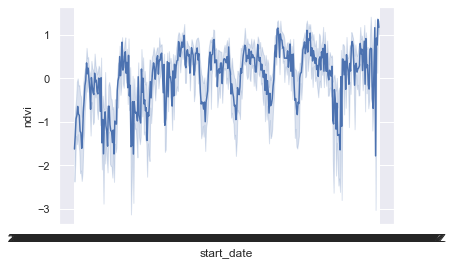

In [207]:
seaborn.set()
fig3 = seaborn.lineplot(x="start_date", y="ndvi", data=features_df)

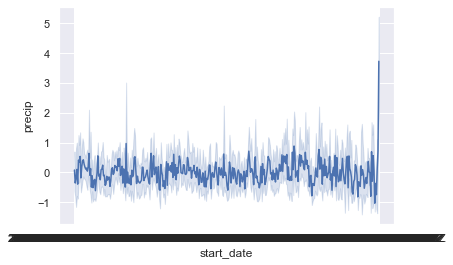

In [208]:
seaborn.set()
fig4 = seaborn.lineplot(x="start_date", y="precip", data=features_df)

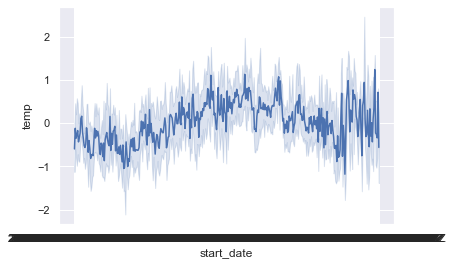

In [209]:
seaborn.set()
fig5 = seaborn.lineplot(x="start_date", y="temp", data=features_df)

In [211]:
int("02")

2

C:\Users\19175\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


help
(405, 159)
(120, 159)
MAPE: 0.454054


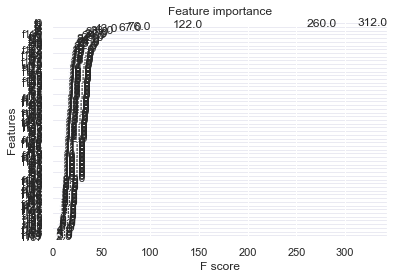

In [212]:
# Johann Hatzius

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
from datetime import datetime
from datetime import timedelta

pd.options.mode.chained_assignment = None

precipitation = pd.read_csv("Daily Precipitation.csv")
soil = pd.read_csv("Daily Soil Mositure.csv")
temperature = pd.read_csv("Daily Temperature.csv")
ndvi = pd.read_csv("Eight Day NDVI.csv")
production = pd.read_csv("Production Quantity.csv")

features = [precipitation, soil, temperature, ndvi]


def find_weekly_sum(x, precip_df, temp_df, soil_df):
    row = ndvi.iloc[x]
    start = row["start_date"]
    end = row["end_date"]
    dates_precip = (precip_df["start_date"] >= start) & (precip_df["start_date"] <= end)
    dates_temp = (temp_df["start_date"] >= start) & (temp_df["start_date"] <= end)
    dates_soil = (soil_df["start_date"] >= start) & (soil_df["start_date"] <= end)
    precip_sum = precip_df.loc[dates_precip]["precip"].sum()
    mean_temp = temp_df.loc[dates_temp]["temp"].mean()
    mean_soil_moisture = soil_df.loc[dates_soil]["smos"].mean()
    new_cols = [precip_sum, mean_temp, mean_soil_moisture]
    return new_cols

def find_regions():
    regions = production["region_id"].tolist()
    return set(regions)

def build_features_df():
    regions = find_regions()
    precip_col = []
    temp_col = []
    smos_col = []
    ndvi_col = []
    for region in regions:
        precip_df = precipitation[precipitation["region_id"] == region]
        temp_df = temperature[temperature["region_id"] == region]
        soil_df = soil[soil["region_id"] == region]
        ndvi_df = ndvi[ndvi["region_id"] == region]
        new_cols = [find_weekly_sum(x, precip_df, temp_df, soil_df) for x in ndvi_df.index]
        new_cols = normalize(new_cols)
        new_cols = np.array(new_cols).transpose()
        new_cols = new_cols.tolist()
        precip_col += new_cols[0]
        temp_col += new_cols[1]
        smos_col += new_cols[2]
        scaler = StandardScaler()
        ndvi_data = np.array(ndvi_df["ndvi"]).reshape(-1,1)
        scaler.fit(ndvi_data)
        ndvi_data = scaler.transform(ndvi_data)
        ndvi_col += list(np.array(ndvi_data).flatten())
    ndvi["precip"] = precip_col
    ndvi["temp"] = temp_col
    ndvi["smos"] = smos_col
    ndvi["ndvi"] = ndvi_col
    features_df = ndvi
    return features_df

def normalize(columns):
    scaler = StandardScaler()
    scaler.fit(columns)
    columns = scaler.transform(columns)
    return columns

def add_month_col():
    production["month"] = [int(x.split('-')[1]) for x in production["start_date"]]
    return production

def create_array_row(x, regional_df):
    row = production.iloc[x]
    start_date = row["start_date"]
    date_int = datetime.strptime(start_date, "%Y-%m-%dT00:00:00.000Z")
    while regional_df["start_date"].isin([start_date]).any() == False:
        date_int = date_int - timedelta(days=1)
        start_date = datetime.strftime(date_int, "%Y-%m-%dT00:00:00.000Z")
        date_int = datetime.strptime(start_date, "%Y-%m-%dT00:00:00.000Z")
    regional_index = int(regional_df[regional_df["start_date"] == start_date].index.values[0])
    features_df = regional_df.loc[regional_index - 38:regional_index]
    features_df = features_df.drop(['start_date', 'end_date', 'region_id'], axis=1)
    features = features_df.to_numpy()
    features_t = features.flatten().tolist()
    final_row = row.tolist() + features_t
    return final_row
    
def create_master_array(features_df):
    production = add_month_col()
    training_data_lst = []
    testing_data_lst = []
    regions = find_regions()
    for region in regions:
        regional_df = features_df[features_df["region_id"] == region]
        prod_df = production[production["region_id"] == region]
        region_list = [create_array_row(x, regional_df) for x in prod_df.index]
        region_data = pd.DataFrame(region_list)
        region_data = region_data.dropna(axis=0)
        region_data = np.array(region_data)
        training_data_lst.append(region_data[:-12, 2:])
        testing_data_lst.append(region_data[-12:, 2:])
    training_data = np.vstack(training_data_lst)
    testing_data = np.vstack(testing_data_lst)
    return (training_data, testing_data)

def xgboost_model(training_data, testing_data):
    X_train, y_train = training_data[:, 1:], training_data[:, :1]
    X_test, y_test = testing_data[:, 1:], testing_data[:, :1]
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', subsample='0.5')
    xg_reg.fit(X_train,y_train)
    preds = xg_reg.predict(X_test)
    mape = np.sqrt(mean_absolute_percentage_error(y_test, preds))
    print("MAPE: %f" % (mape))

if __name__ == '__main__':
    features_df = build_features_df()
    training_data, testing_data = create_master_array(features_df)
    xgboost_model(training_data, testing_data)